In [35]:
from scripts.utils import DataWindow
from scripts.utils import compile_and_fit
from scripts.utils import add_seasonality, encode_ticker, split_date, split_data_frame
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import tensorflow as tf
import numpy as np
import warnings
import os
warnings.filterwarnings('ignore')
from dotenv import load_dotenv

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [36]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 21
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

In [37]:
def create_model(train_df):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(21, train_df.shape[1])))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=21))   # Predict 21 days
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [38]:
val_performance = {}
performance = {}

In [39]:
all_tickers_predictions = pd.DataFrame()
df = pd.read_csv("data/sp500/SP500.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(by="Date")
unique_tickers = df['Ticker'].unique()  # Replace 'Ticker' with the actual column name for tickers
for ticker in unique_tickers:
    ticker_df = df[df['Ticker'] == ticker]

    # Apply your preprocessing functions
    ticker_df = split_date(ticker_df)
    ticker_df.drop(columns = ["Date"], inplace=True)
    # ticker_df = add_seasonality(ticker_df)
    ticker_df = encode_ticker(ticker_df)

    train_df, val_df, test_df = split_data_frame(ticker_df)

    scaler = MinMaxScaler()
    scaler.fit(train_df)

    train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
    val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
    test_df[test_df.columns] = scaler.transform(test_df[test_df.columns]) 

    window = DataWindow(input_width=21, label_width=21, shift=21,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    label_columns=['Close'])
    model = create_model(train_df)
    history = compile_and_fit(model, window)

    val_performance[ticker] = model.evaluate(window.val)
    performance[ticker] = model.evaluate(window.test, verbose=0)
    

Epoch 1/50
291/291 [==============================] - 2s 5ms/step - loss: 0.0635 - mean_absolute_error: 0.1760 - val_loss: 0.2448 - val_mean_absolute_error: 0.3481
Epoch 2/50
291/291 [==============================] - 1s 5ms/step - loss: 0.0112 - mean_absolute_error: 0.0778 - val_loss: 0.1287 - val_mean_absolute_error: 0.2369
Epoch 3/50
291/291 [==============================] - 1s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0574 - val_loss: 0.1025 - val_mean_absolute_error: 0.2139
Epoch 4/50
291/291 [==============================] - 1s 5ms/step - loss: 0.0044 - mean_absolute_error: 0.0477 - val_loss: 0.0762 - val_mean_absolute_error: 0.1791
Epoch 5/50
291/291 [==============================] - 1s 5ms/step - loss: 0.0036 - mean_absolute_error: 0.0428 - val_loss: 0.0582 - val_mean_absolute_error: 0.1572
Epoch 6/50
291/291 [==============================] - 1s 5ms/step - loss: 0.0029 - mean_absolute_error: 0.0385 - val_loss: 0.0754 - val_mean_absolute_error: 0.1861
Epoch 7/50
291/2

In [ ]:
avg_val_performance = np.mean(list(val_performance.values()))
avg_test_performance = np.mean(list(performance.values()))

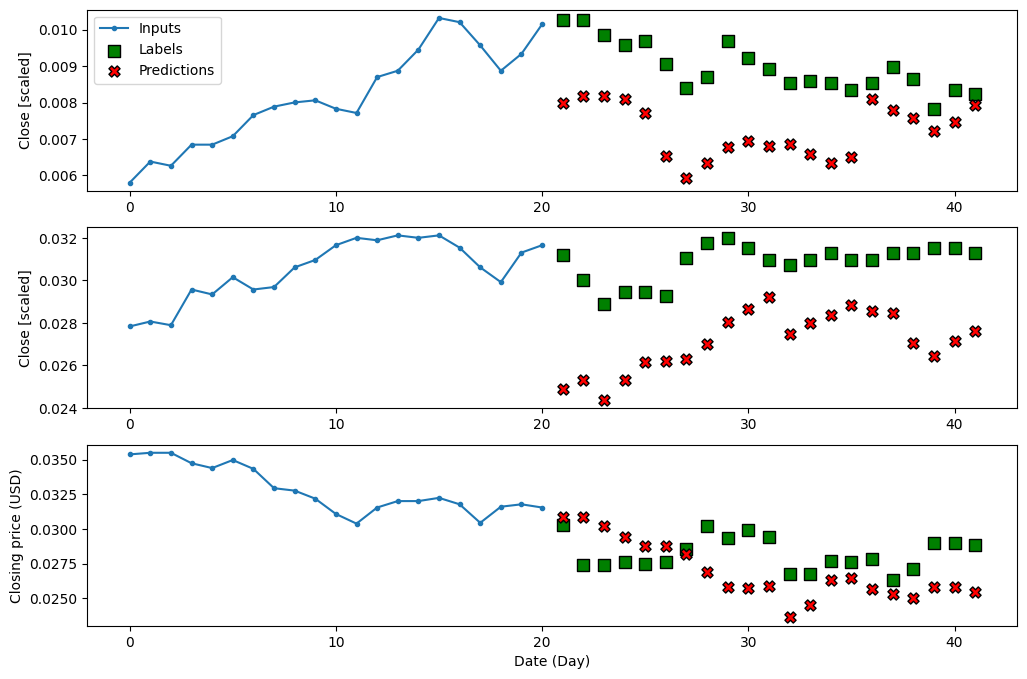

In [ ]:
window.plot(model)